# Fudan PRML Fall 2024 Exercise 4: Unsupervised Learning

![news](./news.png)

**Your name and Student ID:**

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like PyTorch. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [10]:
# setup code
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 1
import os
import pickle
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [11]:
dataset_path = 'kmeans_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
    all_data_np = np.array(all_data)

print ('\n'.join(all_data[0:5]))
print ('Total number of news: {}'.format(len(all_data)))

经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）
虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
如何评价许鞍华导演？她的电影为什么总能给人以触动？
Total number of news: 83360


# 2. Exploratory Data Analysis

Not all data within the dataset is suitable for clustering. You might need to filter and process some of them in advance.

In [12]:
# 2. 数据加载和清洗
dataset_path = 'kmeans_news.pkl'

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join(text.split())
    return text.lower()

# 加载数据
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
    all_data_np = np.array(all_data)

# 清洗数据
cleaned_data = [clean_text(news) for news in all_data]

print('Total number of news:', len(all_data))
print('\nOriginal samples:')
print('\n'.join(all_data[0:3]))
print('\nCleaned samples:')
print('\n'.join(cleaned_data[0:3]))

Total number of news: 83360

Original samples:
经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）

Cleaned samples:
经济学家吴敬琏为什么反对 不惜代价发展芯片产业
颜值很高的她 一双美腿甚至可以让人忽略她的颜值
转自常德诗人 再访桃花源 再续心灵故乡的故事


# 3. Get embeddings for the news

We need to convert the news titles into some kind of numerical representation (embedding) before we can do clustering on them. Below are two ways to get embeddings for a paragraph of text:

1. **Pretrained word embeddings**: You can use pretrained word embeddings like Glove to get embeddings for each word in the news, and then average them (or try some more advanced techniques) to get the news embedding.

2. **General text embedding models**: You can use general text embedding models to get embedding for a sentence directly.

You can choose either of them to convert the news titles into embeddings.

In [13]:
# 1. 首先卸载可能冲突的包
!pip uninstall -y scipy gensim

# 2. 安装指定版本的 scipy
!pip install scipy==1.11.4

# 3. 安装 gensim（使用 --no-deps 避免依赖冲突）
!pip install --no-deps gensim

# 4. 安装 nltk
!pip install nltk

# 5. 重启内核后，运行以下代码
import gensim.downloader as api
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# 加载预训练的GloVe词向量
word_vectors = api.load('glove-wiki-gigaword-100')  # 使用100维的GloVe向量

Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3


You can safely remove it manually.
You can safely remove it manually.


  Using cached scipy-1.11.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp312-cp312-win_amd64.whl (43.7 MB)
  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl (24.0 MB)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\13004\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# 4. 计算TF-IDF权重
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(cleaned_data)
word_to_tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# 5. 定义加权句子嵌入函数
def get_weighted_sentence_embedding(sentence, tfidf_weights):
    tokens = word_tokenize(sentence.lower())
    weighted_vectors = []
    
    for token in tokens:
        if token in word_vectors and token in tfidf_weights:
            weighted_vectors.append(word_vectors[token] * tfidf_weights[token])
    
    if not weighted_vectors:
        return np.zeros(100)
    
    return np.mean(weighted_vectors, axis=0)

# 6. 为所有新闻生成加权embedding
sentence_embeddings = np.array([
    get_weighted_sentence_embedding(news, word_to_tfidf) 
    for news in cleaned_data
])

print(f"Embeddings shape: {sentence_embeddings.shape}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\13004\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total number of news: 83360
Sample of first 5 news:
经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）
虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
如何评价许鞍华导演？她的电影为什么总能给人以触动？
Embeddings shape: (83360, 100)


# 4. Clustering

Do K-means clustering

In [6]:
from sklearn.cluster import KMeans

clusters = 15
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(sentence_embeddings)



View samples in each cluster

In [12]:
random_sample = True
for i in range(clusters):
    print(f'Cluster {i} has {np.sum(kmeans.labels_ == i)} sentences')
    if random_sample:
        print('\n'.join(all_data_np[np.random.choice(np.where(kmeans.labels_ == i)[0], 5)]))
    else:
        print('\n'.join(all_data_np[kmeans.labels_ == i][0:5]))
    print('')

Cluster 0 has 72824 sentences
5月11号英雄联盟MSI，RNG遗憾输给了KZ，怎么评价本局比赛？
中国境内竟还有一支美国军队？差点被遣送回国，外交部长亲自担保
杨幂加盟《奇葩说》网友：她不配！结果第一期辩题就被打脸了
Embraer X发布首款电动垂直起降飞行器概念产品
农村大姐做的农家饭、农家菜、野菜茶，绿色健康有营养

Cluster 1 has 8536 sentences
DOTA回忆录：那个“开挂”的幽鬼王
「灵雀云」获英特尔战略投资，强调“云原生”是未来趋势
狗不理包子“凉了”
“古建筑博物馆”——秀山公园
升格“盐城大学”遥遥无期！能否组建“江苏工业大学”？

Cluster 2 has 635 sentences
预计今年CPI同比涨幅在2%左右 猪肉价格仍将低位运行
龙光地产前四月合约销售额206.6亿元 同比大增80.8%
曹国伟大幅减持新浪股权 投票权却增至55.9%
特朗普提议对美国进口汽车征收20%关税
5月1号以后能不能开具17%、11%增值税发票？怎么处理报税问题？

Cluster 3 has 131 sentences
"操纵股票被罚1.29亿"主持人：认错并按要求缴罚款
日本的"浪人"是什么人？
"天之骄子"苹果之父乔布斯小女儿伊娃的"火辣艺术之路"
遇到了"呼死你"怎么办？
广州外国语学校招生采取"人机对话"，什么是人机对话？

Cluster 4 has 133 sentences
海尔电器(01169.HK)：杨光获委任非执行董事及战略委员会成员
还在傻傻打工？大咖告诉你未来五大行业可以改变命运，震撼！(8)
新股暗盘 | 和铂医药-B(02142)暗盘破发 此前一度大涨超27%
旭辉永升服务(01995.HK）成立市拓小组，多业态结硕果献礼上市两周年
中国中车(01766)重组货车业务成立齐车集团

Cluster 5 has 118 sentences
王室风云:又一个英王室Big Day 新王妃将穿近百万婚纱
上联:霜打秋菊香更烈，如何对下联？
上联:百年恩爱双心结，求下联？
《知否》原著:王舅母—忍辱半生，终于摆脱恶毒小姑子，苦尽甘来
上联:人生不易风风雨雨，怎么对下联？

Cluster 6 has 228 sentences
Android 8.0份额大增，谷歌：多亏这些中国厂商太配

In [13]:
# 1. 分析每个聚类的主题特征
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_cluster_keywords(cluster_texts, top_n=10):
    # 将所有文本合并并分词
    words = []
    for text in cluster_texts:
        tokens = word_tokenize(text.lower())
        # 去除停用词和标点符号
        words.extend([word for word in tokens if word.isalnum() and word not in stop_words])
    
    # 获取最常见的词
    return Counter(words).most_common(top_n)

# 分析每个聚类的关键词
for i in range(clusters):
    cluster_texts = all_data_np[kmeans.labels_ == i]
    keywords = get_cluster_keywords(cluster_texts)
    print(f"\nCluster {i} ({len(cluster_texts)} articles)")
    print("Top keywords:", ', '.join([f"{word}({count})" for word, count in keywords]))

# 2. 评估聚类质量
from sklearn.metrics import silhouette_score, calinski_harabasz_score

silhouette_avg = silhouette_score(sentence_embeddings, kmeans.labels_)
calinski_harabasz_avg = calinski_harabasz_score(sentence_embeddings, kmeans.labels_)

print("\n=== Clustering Quality Metrics ===")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg:.3f}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\13004\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.



Cluster 0 (72824 articles)
Top keywords: oppo(16), 俄罗斯一武装直升机在叙利亚坠毁(9), 说一段曹操墓的闲话(9), 2018(8), 王者荣耀(7), 申通员工降薪最狠(6), 楼市调控政策今年已发上百个(6), 实拍(6), 中国赠送马克思雕像在德国特里尔揭幕(5), 特朗普宣布退出伊核协议(5)

Cluster 1 (8536 articles)
Top keywords: 农村俗语(24), 和(24), 农村老话(23), 活动(23), 与(23), 人造猪肉(22), 从(22), 中国(20), 到(20), 了(20)

Cluster 2 (635 articles)
Top keywords: 从20(10), 关税(6), 以上(6), 左右(4), 企业工资指导线迎密集调整(4), 股权(4), 京东健康上市次日涨2(4), 市值站稳3500亿港元(4), 外贸延续稳中向好(3), 平均涨幅将超过7(3)

Cluster 3 (131 articles)
Top keywords: 死(3), 5g芯片(3), 中兴通讯(3), 如何看待美国将长时间停止对(3), 白头盔(3), 发布(2), 北上广深不相信电单车(2), 共享单车终究走向(2), 水清则无鱼(2), 天之骄子(2)

Cluster 4 (133 articles)
Top keywords: 2(4), 光在处于收缩状态下的空间(3), 真空(3), 4(3), 评级(3), 1(3), 5(3), 股权(3), 8(3), 3(3)

Cluster 5 (118 articles)
Top keywords: 上联(51), 下联(14), 对联(7), woj大神爆料(2), 首联(2), 上句(2), 李隼指导直言(2), 刺激战场(2), 复仇者联盟3的导演接受采访直言(1), 故事(1)

Cluster 6 (228 articles)
Top keywords: vs(17), iphone(14), vivo(12), 2018(8), google(8), p(8), android(7), x(5), ios(5), 360(4)

Cluster 7 (46 articles)
Top k

In [ ]:
# 找到最优聚类数量
def find_optimal_clusters(embeddings, max_clusters=20):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

# 使用最优聚类数量
optimal_clusters = find_optimal_clusters(sentence_embeddings)
print(f"Optimal number of clusters: {optimal_clusters}")

# 使用最优聚类数量进行聚类
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(sentence_embeddings)

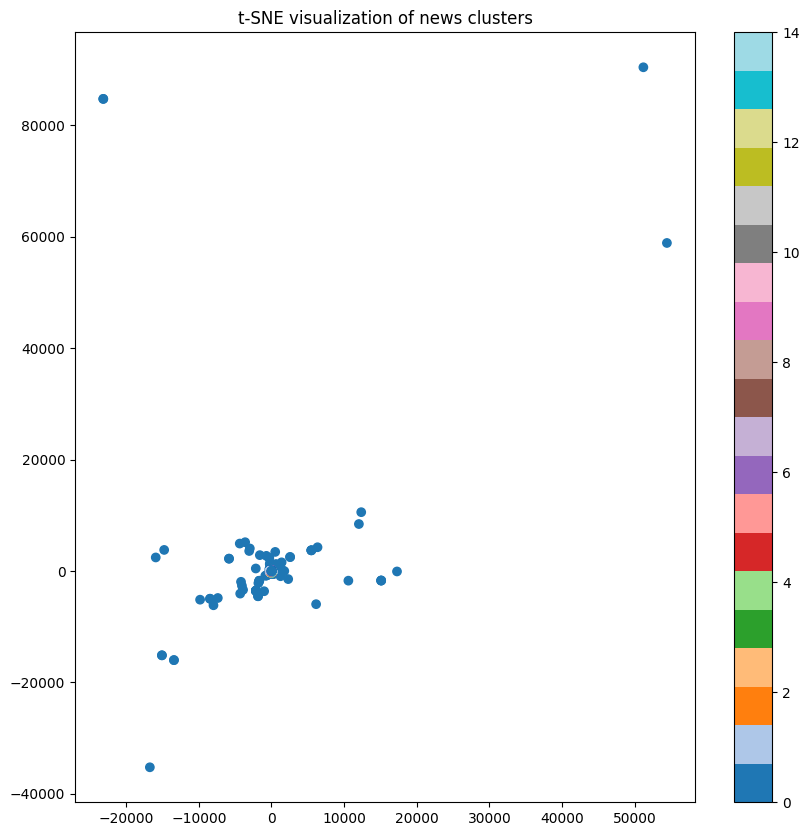

In [14]:
# 使用t-SNE进行降维可视化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 降维到2D
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(sentence_embeddings)

# 绘制散点图
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=kmeans.labels_, cmap='tab20')
plt.colorbar(scatter)
plt.title('t-SNE visualization of news clusters')
plt.show()